In [1]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import utils
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
seq_dict = utils.get_sequence_dict("dataset/NEIS2157.json")

In [3]:
from autoembedding.combiners import combiner_for_prose
IDs = utils.get_ordered_ids(seq_dict)

embeddings_matrix =[]

for id in IDs:
    final_embedding = combiner_for_prose(
        raw_embedding = np.array(seq_dict[id]["embedding3"]),  # is a (seq_len)*(100) matrix (each row is the embedding of an amminoacid)
        method = "average"
    ) 
    
    embeddings_matrix.append(final_embedding)

embeddings_matrix = np.array(embeddings_matrix)
embeddings_matrix.shape

(27, 100)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [105.0, 105.0, 115.0, 115.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [135.0, 135.0, 153.75, 153.75],
  [125.0, 125.0, 144.375, 144.375],
  [110.0, 110.0, 134.6875, 134.6875],
  [95.0, 95.0, 122.34375, 122.34375],
  [85.0, 85.0, 108.671875, 108.671875],
  [195.0, 195.0, 205.0, 205.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [222.5, 222.5, 252.5, 252.5],
  [200.0, 200.0, 237.5, 237.5],
  [185.0, 185.0, 218.75, 218.75],
  [96.8359375, 96.8359375, 201.875, 201.875],
  [75.0, 75.0, 149.35546875, 149.35546875],
  [43.75, 43.75, 112.177734375, 112.177734375],
  [25.0, 25.0, 77.9638671875, 77.9638671875],
  [10.0, 10.0, 51.48193359375, 51.48193359375]],
 'dcoord': [[0.0, 0.08994180582965969, 0.08994180582965969, 0.0],
  [0.0, 0

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [75.0, 75.0, 85.0, 85.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [195.0, 195.0, 214.375, 214.375],
  [255.0, 255.0, 265.0, 265.0],
  [204.6875, 204.6875, 260.0, 260.0],
  [185.0, 185.0, 232.34375, 232.34375],
  [175.0, 175.0, 208.671875, 208.671875],
  [165.0, 165.0, 191.8359375, 191.8359375],
  [155.0, 155.0, 178.41796875, 178.41796875],
  [145.0, 145.0, 166.708984375, 166.708984375],
  [135.0, 135.0, 155.8544921875, 155.8544921875],
  [125.0, 125.0, 145.42724609375, 145.42724609375],
  [115.0, 115.0, 135.213623046875, 135.213623046875],
  [105.0, 105.0, 125.1068115234375, 125.1068115234375],
  [95.0, 95.0, 115.05340576171875, 115.05340576171875],
  [80.0, 80.0, 105.02670288085938, 105.02670288085938],
  [65.0, 65.0, 92.51335144042969, 92.51335144042969],
  [55.0, 55.0, 78.75667572021484, 78.75667572021484],
  [45.0, 45.0, 66.87833786010742, 66.87833786010

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [75.0, 75.0, 100.0, 100.0],
  [60.0, 60.0, 87.5, 87.5],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [195.0, 195.0, 212.5, 212.5],
  [185.0, 185.0, 203.75, 203.75],
  [175.0, 175.0, 194.375, 194.375],
  [165.0, 165.0, 184.6875, 184.6875],
  [155.0, 155.0, 174.84375, 174.84375],
  [145.0, 145.0, 164.921875, 164.921875],
  [135.0, 135.0, 154.9609375, 154.9609375],
  [125.0, 125.0, 144.98046875, 144.98046875],
  [73.75, 73.75, 134.990234375, 134.990234375],
  [45.0, 45.0, 104.3701171875, 104.3701171875],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [74.68505859375, 74.68505859375, 243.75, 243.75],
  [35.0, 35.0, 159.217529296875, 159.217529296875],
  [25.0, 25.0, 97.1087646484375, 97.1087646484375],
  [10.0, 10.0, 61.05438232421875, 61.05438232421875]],
 'dcoord'

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [105.0, 105.0, 115.0, 115.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [195.0, 195.0, 214.375, 214.375],
  [255.0, 255.0, 265.0, 265.0],
  [204.6875, 204.6875, 260.0, 260.0],
  [185.0, 185.0, 232.34375, 232.34375],
  [175.0, 175.0, 208.671875, 208.671875],
  [165.0, 165.0, 191.8359375, 191.8359375],
  [155.0, 155.0, 178.41796875, 178.41796875],
  [145.0, 145.0, 166.708984375, 166.708984375],
  [135.0, 135.0, 155.8544921875, 155.8544921875],
  [125.0, 125.0, 145.42724609375, 145.42724609375],
  [110.0, 110.0, 135.213623046875, 135.213623046875],
  [95.0, 95.0, 122.6068115234375, 122.6068115234375],
  [72.5, 72.5, 108.80340576171875, 108.80340576171875],
  [55.0, 55.0, 90.65170288085938, 90.65170288085938],
  [45.0, 45.0, 72.82585144042969, 72.82585144042969],
  [35.0, 35.0, 58.912925720214844, 58.91292572

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [195.0, 195.0, 214.375, 214.375],
  [255.0, 255.0, 265.0, 265.0],
  [204.6875, 204.6875, 260.0, 260.0],
  [185.0, 185.0, 232.34375, 232.34375],
  [175.0, 175.0, 208.671875, 208.671875],
  [165.0, 165.0, 191.8359375, 191.8359375],
  [155.0, 155.0, 178.41796875, 178.41796875],
  [145.0, 145.0, 166.708984375, 166.708984375],
  [122.5, 122.5, 155.8544921875, 155.8544921875],
  [105.0, 105.0, 139.17724609375, 139.17724609375],
  [82.5, 82.5, 122.088623046875, 122.088623046875],
  [65.0, 65.0, 102.2943115234375, 102.2943115234375],
  [55.0, 55.0, 83.64715576171875, 83.64715576171875],
  [45.0, 45.0, 69.32357788085938, 69.32357788085938],
  [35.0, 35.0, 57.16178894042969, 57.16178894042969],
  [25.0, 25.0, 46.

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [115.0, 115.0, 133.75, 133.75],
  [105.0, 105.0, 124.375, 124.375],
  [95.0, 95.0, 114.6875, 114.6875],
  [85.0, 85.0, 104.84375, 104.84375],
  [75.0, 75.0, 94.921875, 94.921875],
  [65.0, 65.0, 84.9609375, 84.9609375],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [195.0, 195.0, 212.5, 212.5],
  [172.5, 172.5, 203.75, 203.75],
  [74.98046875, 74.98046875, 188.125, 188.125],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [131.552734375, 131.552734375, 243.75, 243.75],
  [55.0, 55.0, 187.6513671875, 187.6513671875],
  [45.0, 45.0, 121.32568359375, 121.32568359375],
  [35.0, 35.0, 83.162841796875, 83.162841796875],
  [25.0, 25.0, 59.0814208984375, 59.0814208984375],
  [10.0, 10.0, 42.04071044921875, 42.04071044921875]],
 'd

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [195.0, 195.0, 214.375, 214.375],
  [255.0, 255.0, 265.0, 265.0],
  [204.6875, 204.6875, 260.0, 260.0],
  [185.0, 185.0, 232.34375, 232.34375],
  [175.0, 175.0, 208.671875, 208.671875],
  [165.0, 165.0, 191.8359375, 191.8359375],
  [155.0, 155.0, 178.41796875, 178.41796875],
  [145.0, 145.0, 166.708984375, 166.708984375],
  [135.0, 135.0, 155.8544921875, 155.8544921875],
  [112.5, 112.5, 145.42724609375, 145.42724609375],
  [95.0, 95.0, 128.963623046875, 128.963623046875],
  [72.5, 72.5, 111.9818115234375, 111.9818115234375],
  [55.0, 55.0, 92.24090576171875, 92.24090576171875],
  [45.0, 45.0, 73.62045288085938, 73.62045288085938],
  [35.0, 35.0, 59.31022644042969, 59.31022644042969],
  [25.0, 25.0, 47.

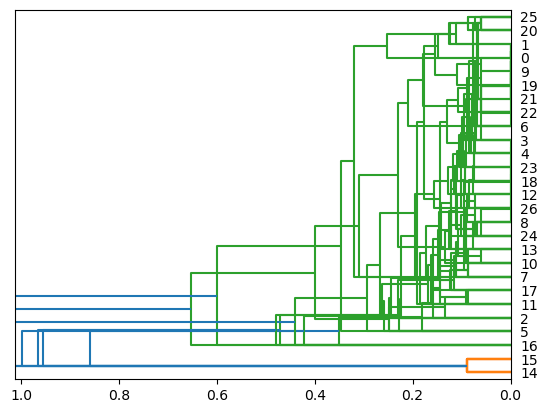

In [4]:
methods = ["ward", "single", "complete", "centroid", "median", "weighted", "average"]


for method in methods:
    # Perform hierarchical clustering
    Z = linkage(embeddings_matrix, method=method)
    # Plot dendrogram
    dendrogram(Z, orientation="left")

# Get cluster labels
#max_d =30  # set the maximum distance between clusters
#labels = fcluster(Z, max_d, criterion='distance')
#print(labels)

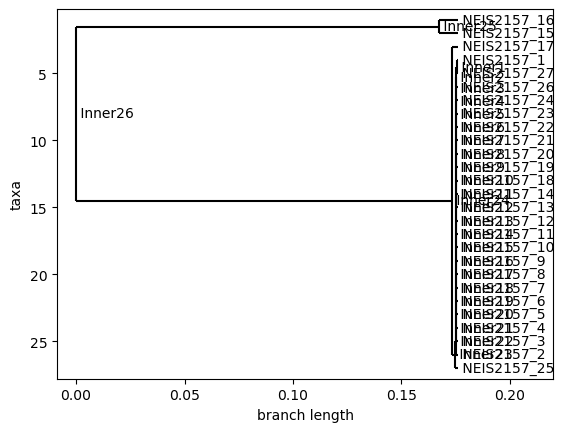

In [5]:
from Bio.Align.Applications import MuscleCommandline
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor


cline = MuscleCommandline(input="dataset/NEIS2157.fasta", out="dataset/NEIS2157_alignment.fasta")
#cline()


# Read the alignment file in FASTA format
alignment = AlignIO.read("dataset/NEIS2157_alignment.fasta", "fasta")

# Create a distance calculator and calculate the distance matrix
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)

# Build a tree from the distance matrix using the maximum likelihood method
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(alignment)

# Print the tree in ASCII art format
Phylo.draw(tree)

